In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency
import imblearn
import sklearn
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

In [2]:
test_data = pd.read_csv('test.csv')
train_data = pd.read_csv('train.csv')

Train Data

In [3]:
train_data

,Patient Id,Patient Age,Genes in mother's side,Inherited from father,Maternal gene,Paternal gene,Blood cell count (mcL),Patient First Name,Family Name,Father's name,...,Birth defects,White Blood cell count (thousand per microliter),Blood test result,Symptom 1,Symptom 2,Symptom 3,Symptom 4,Symptom 5,Genetic Disorder,Disorder Subclass
0,PID0x6418,2.0,Yes,No,Yes,No,4.760603,Richard,NaN,Larre,...,NaN,9.857562,NaN,1.0,1.0,1.0,1.0,1.0,Mitochondrial genetic inheritance disorders,Leber's hereditary optic neuropathy
1,PID0x25d5,4.0,Yes,Yes,No,No,4.910669,Mike,NaN,Brycen,...,Multiple,5.522560,normal,1.0,NaN,1.0,1.0,0.0,NaN,Cystic fibrosis
2,PID0x4a82,6.0,Yes,No,No,No,4.893297,Kimberly,NaN,Nashon,...,Singular,NaN,normal,0.0,1.0,1.0,1.0,1.0,Multifactorial genetic inheritance disorders,Diabetes
3,PID0x4ac8,12.0,Yes,No,Yes,No,4.705280,Jeffery,Hoelscher,Aayaan,...,Singular,7.919321,inconclusive,0.0,0.0,1.0,0.0,0.0,Mitochondrial genetic inheritance disorders,Leigh syndrome
4,PID0x1bf7,11.0,Yes,No,NaN,Yes,4.720703,Johanna,Stutzman,Suave,...,Multiple,4.098210,NaN,0.0,0.0,0.0,0.0,NaN,Multifactorial genetic inheritance disorders,Cancer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22078,PID0x5598,4.0,Yes,Yes,Yes,No,5.258298,Lynn,NaN,Alhassane,...,Multiple,6.584811,inconclusive,0.0,0.0,1.0,0.0,0.0,Mitochondrial genetic inheritance disorders,Leigh syndrome
22079,PID0x19cb,8.0,No,Yes,No,Yes,4.974220,Matthew,Farley,Dartanion,...,Multiple,7.041556,inconclusive,1.0,1.0,1.0,1.0,0.0,Multifactorial genetic inheritance disorders,Diabetes
22080,PID0x3c4f,8.0,Yes,No,Yes,No,5.186470,John,NaN,Cavani,...,Singular,7.715464,normal,0.0,0.0,0.0,1.0,NaN,Mitochondrial genetic inheritance disorders,Mitochondrial myopathy
22081,PID0x13a,7.0,Yes,No,Yes,Yes,4.858543,Sharon,NaN,Bomer,...,Multiple,8.437670,abnormal,1.0,1.0,1.0,0.0,0.0,NaN,Leigh syndrome


Test Data

In [4]:
test_data

,Patient Id,Patient Age,Genes in mother's side,Inherited from father,Maternal gene,Paternal gene,Blood cell count (mcL),Patient First Name,Family Name,Father's name,...,History of anomalies in previous pregnancies,No. of previous abortion,Birth defects,White Blood cell count (thousand per microliter),Blood test result,Symptom 1,Symptom 2,Symptom 3,Symptom 4,Symptom 5
0,PID0x4175,6,No,Yes,No,No,4.981655,Charles,NaN,Kore,...,-99,2,Multiple,-99.000000,slightly abnormal,True,True,True,True,True
1,PID0x21f5,10,Yes,No,NaN,Yes,5.118890,Catherine,NaN,Homero,...,Yes,-99,Multiple,8.179584,normal,False,False,False,True,False
2,PID0x49b8,5,No,NaN,No,No,4.876204,James,NaN,Danield,...,No,0,Singular,-99.000000,slightly abnormal,False,False,True,True,False
3,PID0x2d97,13,No,Yes,Yes,No,4.687767,Brian,NaN,Orville,...,Yes,-99,Singular,6.884071,normal,True,False,True,False,True
4,PID0x58da,5,No,NaN,NaN,Yes,5.152362,Gary,NaN,Issiah,...,No,-99,Multiple,6.195178,normal,True,True,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9460,PID0x81e1,9,Yes,Yes,NaN,No,4.878335,Francisco,NaN,Artavian,...,Yes,2,Multiple,7.234960,abnormal,False,True,True,True,False
9461,PID0x3514,1,Yes,No,NaN,Yes,4.927151,James,NaN,Nasir,...,No,-99,Singular,4.859536,abnormal,False,True,False,True,True
9462,PID0x5408,2,No,Yes,No,No,4.898352,Rebecca,NaN,Jatorian,...,No,3,-99,5.696062,normal,False,True,False,False,True
9463,PID0x2017,13,No,Yes,No,No,4.804840,Daryl,NaN,Keevis,...,-99,1,Singular,3.000000,inconclusive,True,True,True,True,True


In [5]:
# Remove quotes and replace spaces with underscores
train_data.columns = [col.strip().replace("'", '').replace(' ', '_') for col in train_data.columns]

test_data.columns = [col.strip().replace("'", '').replace(' ', '_') for col in test_data.columns]

In [6]:
train_data = train_data.rename(columns={
    'Genes_in_mothers_side': 'Genes_Mothers_Side',
    'Inherited_from_father': 'Inherited_Father',
    'Blood_cell_count_(mcL)': 'Blood_Cell_mcL',
    'Respiratory_Rate_(breaths/min)': 'Respiratory_Rate_breaths_min',
    'Heart_Rate_(rates/min': 'Heart_Rates_Min',
    'Follow-up': 'Follow_up',
    'Autopsy_shows_birth_defect_(if_applicable)': 'Autopsy_Birth_Defect',
    'Folic_acid_details_(peri-conceptional)': 'Folic_Acid',
    'H/O_serious_maternal_illness': 'Maternal_Illness',
    'H/O_radiation_exposure_(x-ray)': 'Radiation_Exposure',
    'H/O_substance_abuse': 'Substance_Abuse',
    'Assisted_conception_IVF/ART': 'Assisted_Conception',
    'History_of_anomalies_in_previous_pregnancies': 'History_Previous_Pregnancies',
    'No._of_previous_abortion': 'Previous_Abortion',
    'Birth_defects': 'Birth_Defects',
    'White_Blood_cell_count_(thousand_per_microliter)': 'White_Blood_Cell',
})

In [7]:
train_data.columns

Index(['Patient_Id', 'Patient_Age', 'Genes_Mothers_Side', 'Inherited_Father',
       'Maternal_gene', 'Paternal_gene', 'Blood_Cell_mcL',
       'Patient_First_Name', 'Family_Name', 'Fathers_name', 'Mothers_age',
       'Fathers_age', 'Institute_Name', 'Location_of_Institute', 'Status',
       'Respiratory_Rate_breaths_min', 'Heart_Rates_Min', 'Test_1', 'Test_2',
       'Test_3', 'Test_4', 'Test_5', 'Parental_consent', 'Follow_up', 'Gender',
       'Birth_asphyxia', 'Autopsy_Birth_Defect', 'Place_of_birth',
       'Folic_Acid', 'Maternal_Illness', 'Radiation_Exposure',
       'Substance_Abuse', 'Assisted_Conception',
       'History_Previous_Pregnancies', 'Previous_Abortion', 'Birth_Defects',
       'White_Blood_Cell', 'Blood_test_result', 'Symptom_1', 'Symptom_2',
       'Symptom_3', 'Symptom_4', 'Symptom_5', 'Genetic_Disorder',
       'Disorder_Subclass'],
      dtype='object')

If Genetic_Disorder is NaN, removing those rows

In [8]:
# Drop rows where 'Genetic_Disorder' is NaN
train_data.dropna(subset=['Genetic_Disorder'], inplace=True)

# Reset the index to update row numbers and avoid keeping the old index
train_data.reset_index(drop=True, inplace=True)

Dropping the unnecessary data columns - Based on Optimised Paper

In [9]:
train_data = train_data.drop(columns=['Patient_Id','Patient_First_Name', 'Family_Name',
       'Fathers_name','Institute_Name', 'Place_of_birth',
       'Location_of_Institute', 'Test_1', 'Test_2', 'Test_3', 'Test_4',
       'Test_5', 
       'Symptom_1', 'Symptom_2', 'Symptom_3', 'Symptom_4', 'Symptom_5'])

In [10]:
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19937 entries, 0 to 19936
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Patient_Age                   18712 non-null  float64
 1   Genes_Mothers_Side            19937 non-null  object 
 2   Inherited_Father              19676 non-null  object 
 3   Maternal_gene                 17513 non-null  object 
 4   Paternal_gene                 19937 non-null  object 
 5   Blood_Cell_mcL                19937 non-null  float64
 6   Mothers_age                   14733 non-null  float64
 7   Fathers_age                   14772 non-null  float64
 8   Status                        19937 non-null  object 
 9   Respiratory_Rate_breaths_min  18111 non-null  object 
 10  Heart_Rates_Min               18132 non-null  object 
 11  Parental_consent              18118 non-null  object 
 12  Follow_up                     18075 non-null  object 
 13  G

In [11]:
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Patient_Age,18712.0,6.973814,4.317123,0.00000,3.000000,7.000000,11.000000,14.000000
Blood_Cell_mcL,19937.0,4.899020,0.199268,4.14623,4.763531,4.899875,5.033669,5.609829
Mothers_age,14733.0,34.555691,9.837057,18.00000,26.000000,35.000000,43.000000,51.000000
Fathers_age,14772.0,41.982602,13.038188,20.00000,30.000000,42.000000,53.000000,64.000000
Previous_Abortion,18109.0,1.999669,1.411399,0.00000,1.000000,2.000000,3.000000,4.000000
White_Blood_Cell,18088.0,7.482977,2.650108,3.00000,5.429574,7.472366,9.521766,12.000000


In [12]:
train_data.isnull().sum()

Patient_Age                     1225
Genes_Mothers_Side                 0
Inherited_Father                 261
Maternal_gene                   2424
Paternal_gene                      0
Blood_Cell_mcL                     0
Mothers_age                     5204
Fathers_age                     5165
Status                             0
Respiratory_Rate_breaths_min    1826
Heart_Rates_Min                 1805
Parental_consent                1819
Follow_up                       1862
Gender                          1844
Birth_asphyxia                  1848
Autopsy_Birth_Defect            3935
Folic_Acid                      1814
Maternal_Illness                1824
Radiation_Exposure              1830
Substance_Abuse                 1900
Assisted_Conception             1847
History_Previous_Pregnancies    1893
Previous_Abortion               1828
Birth_Defects                   1839
White_Blood_Cell                1849
Blood_test_result               1833
Genetic_Disorder                   0
D

In [13]:
train_data.duplicated().sum()

0

In [14]:
train_data.columns

Index(['Patient_Age', 'Genes_Mothers_Side', 'Inherited_Father',
       'Maternal_gene', 'Paternal_gene', 'Blood_Cell_mcL', 'Mothers_age',
       'Fathers_age', 'Status', 'Respiratory_Rate_breaths_min',
       'Heart_Rates_Min', 'Parental_consent', 'Follow_up', 'Gender',
       'Birth_asphyxia', 'Autopsy_Birth_Defect', 'Folic_Acid',
       'Maternal_Illness', 'Radiation_Exposure', 'Substance_Abuse',
       'Assisted_Conception', 'History_Previous_Pregnancies',
       'Previous_Abortion', 'Birth_Defects', 'White_Blood_Cell',
       'Blood_test_result', 'Genetic_Disorder', 'Disorder_Subclass'],
      dtype='object')

In [15]:
print(train_data["Genes_Mothers_Side"].value_counts())

Genes_Mothers_Side
Yes    11848
No      8089
Name: count, dtype: int64


In [16]:
print(train_data['Genetic_Disorder'].value_counts())

Genetic_Disorder
Mitochondrial genetic inheritance disorders     10202
Single-gene inheritance diseases                 7664
Multifactorial genetic inheritance disorders     2071
Name: count, dtype: int64


In [17]:
def get_unique(train_data):
    for i in train_data.columns:
        print(f'{i} - > {len(train_data[i].unique())}')
get_unique(train_data)

Patient_Age - > 16
Genes_Mothers_Side - > 2
Inherited_Father - > 3
Maternal_gene - > 3
Paternal_gene - > 2
Blood_Cell_mcL - > 19937
Mothers_age - > 35
Fathers_age - > 46
Status - > 2
Respiratory_Rate_breaths_min - > 3
Heart_Rates_Min - > 3
Parental_consent - > 2
Follow_up - > 3
Gender - > 4
Birth_asphyxia - > 5
Autopsy_Birth_Defect - > 4
Folic_Acid - > 3
Maternal_Illness - > 3
Radiation_Exposure - > 5
Substance_Abuse - > 5
Assisted_Conception - > 3
History_Previous_Pregnancies - > 3
Previous_Abortion - > 6
Birth_Defects - > 3
White_Blood_Cell - > 15682
Blood_test_result - > 5
Genetic_Disorder - > 3
Disorder_Subclass - > 10


In [18]:
# Continuous features with median imputation
train_data['Patient_Age'].fillna(train_data['Patient_Age'].median(), inplace=True)
train_data['Blood_Cell_mcL'].fillna(train_data['Blood_Cell_mcL'].median(), inplace=True)
train_data['White_Blood_Cell'].fillna(train_data['White_Blood_Cell'].median(), inplace=True)

# Categorical/ordinal features with mode imputation
columns_to_fill_mode = [
    'Genes_Mothers_Side', 'Inherited_Father', 'Maternal_gene', 'Paternal_gene','Mothers_age',
    'Fathers_age','Status', 'Respiratory_Rate_breaths_min', 'Heart_Rates_Min', 
    'Parental_consent', 'Follow_up', 'Gender', 'Birth_asphyxia','Autopsy_Birth_Defect',  
    'Folic_Acid', 
    'Maternal_Illness', 'Radiation_Exposure', 
    'Substance_Abuse', 'Assisted_Conception', 
    'History_Previous_Pregnancies','Previous_Abortion', 'Birth_Defects', 
    'Blood_test_result', 'Disorder_Subclass'
]

for col in columns_to_fill_mode:
    train_data[col].fillna(train_data[col].mode()[0], inplace=True)



In [19]:
train_data.isnull().sum()

Patient_Age                     0
Genes_Mothers_Side              0
Inherited_Father                0
Maternal_gene                   0
Paternal_gene                   0
Blood_Cell_mcL                  0
Mothers_age                     0
Fathers_age                     0
Status                          0
Respiratory_Rate_breaths_min    0
Heart_Rates_Min                 0
Parental_consent                0
Follow_up                       0
Gender                          0
Birth_asphyxia                  0
Autopsy_Birth_Defect            0
Folic_Acid                      0
Maternal_Illness                0
Radiation_Exposure              0
Substance_Abuse                 0
Assisted_Conception             0
History_Previous_Pregnancies    0
Previous_Abortion               0
Birth_Defects                   0
White_Blood_Cell                0
Blood_test_result               0
Genetic_Disorder                0
Disorder_Subclass               0
dtype: int64

In [20]:
print("Status: ",train_data["Status"].unique())
print("Respiratory Rate (breaths/min): ",train_data["Respiratory_Rate_breaths_min"].unique())
print("Heart Rate: ",train_data["Heart_Rates_Min"].unique())
print("Follow-up: ",train_data["Follow_up"].unique())
print("Gender: ",train_data["Gender"].unique())
print("Autopsy shows birth defect: ",train_data["Autopsy_Birth_Defect"].unique())
print("Birth defects: ",train_data["Birth_Defects"].unique())
print("Blood test result: ",train_data["Blood_test_result"].unique())
print("Genetic Disorder: ",train_data["Genetic_Disorder"].unique())
print("Disorder Subclass: ",train_data["Disorder_Subclass"].unique())

Status:  ['Alive' 'Deceased']
Respiratory Rate (breaths/min):  ['Normal (30-60)' 'Tachypnea']
Heart Rate:  ['Normal' 'Tachycardia']
Follow-up:  ['High' 'Low']
Gender:  ['Ambiguous' 'Male' 'Female']
Autopsy shows birth defect:  ['Not applicable' 'No' 'Yes']
Birth defects:  ['Multiple' 'Singular']
Blood test result:  ['slightly abnormal' 'normal' 'inconclusive' 'abnormal']
Genetic Disorder:  ['Mitochondrial genetic inheritance disorders'
 'Multifactorial genetic inheritance disorders'
 'Single-gene inheritance diseases']
Disorder Subclass:  ["Leber's hereditary optic neuropathy" 'Diabetes' 'Leigh syndrome'
 'Cancer' 'Cystic fibrosis' 'Tay-Sachs' 'Hemochromatosis'
 'Mitochondrial myopathy' "Alzheimer's"]


In [21]:
train_data

,Patient_Age,Genes_Mothers_Side,Inherited_Father,Maternal_gene,Paternal_gene,Blood_Cell_mcL,Mothers_age,Fathers_age,Status,Respiratory_Rate_breaths_min,...,Radiation_Exposure,Substance_Abuse,Assisted_Conception,History_Previous_Pregnancies,Previous_Abortion,Birth_Defects,White_Blood_Cell,Blood_test_result,Genetic_Disorder,Disorder_Subclass
0,2.0,Yes,No,Yes,No,4.760603,23.0,20.0,Alive,Normal (30-60),...,No,No,No,Yes,2.0,Multiple,9.857562,slightly abnormal,Mitochondrial genetic inheritance disorders,Leber's hereditary optic neuropathy
1,6.0,Yes,No,No,No,4.893297,41.0,22.0,Alive,Normal (30-60),...,Yes,No,Yes,Yes,4.0,Singular,7.472366,normal,Multifactorial genetic inheritance disorders,Diabetes
2,12.0,Yes,No,Yes,No,4.705280,21.0,20.0,Deceased,Tachypnea,...,-,Not applicable,Yes,Yes,1.0,Singular,7.919321,inconclusive,Mitochondrial genetic inheritance disorders,Leigh syndrome
3,11.0,Yes,No,Yes,Yes,4.720703,32.0,20.0,Alive,Tachypnea,...,-,Not applicable,Yes,No,4.0,Multiple,4.098210,slightly abnormal,Multifactorial genetic inheritance disorders,Cancer
4,14.0,Yes,No,Yes,No,5.103188,23.0,20.0,Deceased,Normal (30-60),...,No,No,Yes,No,0.0,Multiple,10.272230,normal,Single-gene inheritance diseases,Cystic fibrosis
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19932,9.0,No,Yes,Yes,Yes,5.012599,47.0,20.0,Deceased,Normal (30-60),...,No,Not applicable,Yes,Yes,2.0,Multiple,12.000000,slightly abnormal,Mitochondrial genetic inheritance disorders,Leigh syndrome
19933,4.0,Yes,Yes,Yes,No,5.258298,35.0,64.0,Deceased,Normal (30-60),...,Not applicable,No,Yes,No,3.0,Multiple,6.584811,inconclusive,Mitochondrial genetic inheritance disorders,Leigh syndrome
19934,8.0,No,Yes,No,Yes,4.974220,23.0,56.0,Alive,Normal (30-60),...,No,-,Yes,No,2.0,Multiple,7.041556,inconclusive,Multifactorial genetic inheritance disorders,Diabetes
19935,8.0,Yes,No,Yes,No,5.186470,35.0,51.0,Deceased,Tachypnea,...,Not applicable,No,No,No,2.0,Singular,7.715464,normal,Mitochondrial genetic inheritance disorders,Mitochondrial myopathy


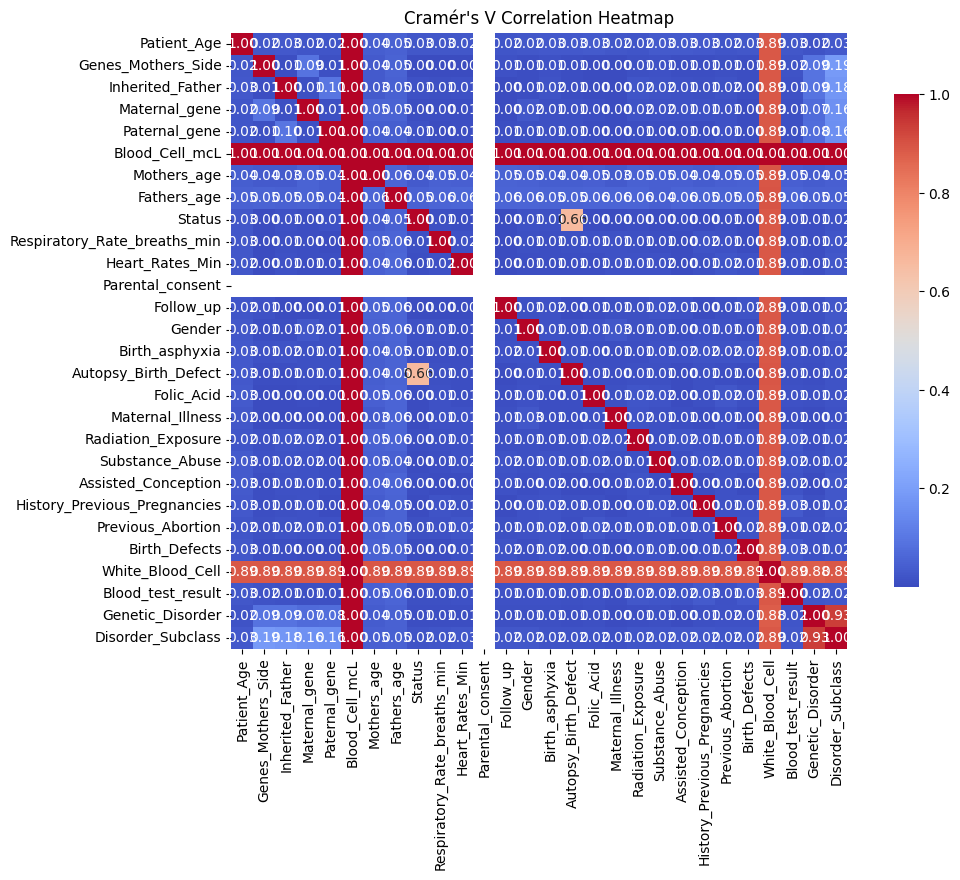

In [100]:
# Function to calculate Cramér's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    return np.sqrt(chi2 / (n * (min(confusion_matrix.shape)-1)))

# Create a Cramér's V correlation matrix
def cramers_v_matrix(data):
    cols = data.columns
    correlation_matrix = pd.DataFrame(index=cols, columns=cols)

    for i in range(len(cols)):
        for j in range(len(cols)):
            correlation_matrix.iloc[i, j] = cramers_v(data[cols[i]], data[cols[j]])

    return correlation_matrix.astype(float)

# Assuming train_data is your DataFrame with all categorical values
cramers_v_corr = cramers_v_matrix(train_data)

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cramers_v_corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title("Cramér's V Correlation Heatmap")
plt.show()

# EDA

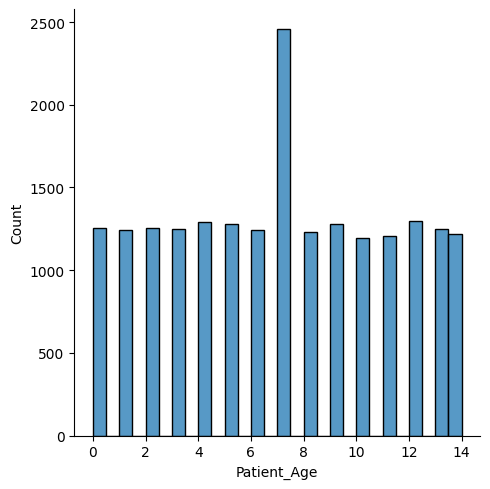

In [23]:
#plt.style.use('seaborn-dark')
sns.displot(x = 'Patient_Age', data = train_data);

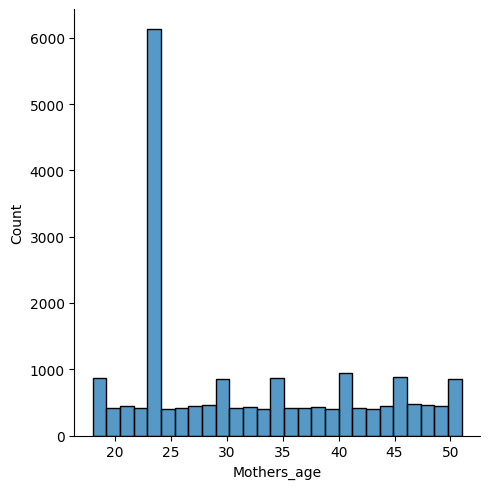

In [24]:
sns.displot(x = 'Mothers_age', data = train_data);

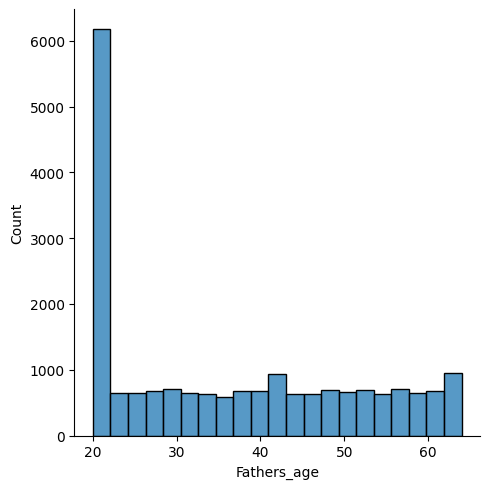

In [25]:
sns.displot(x = 'Fathers_age', data = train_data);

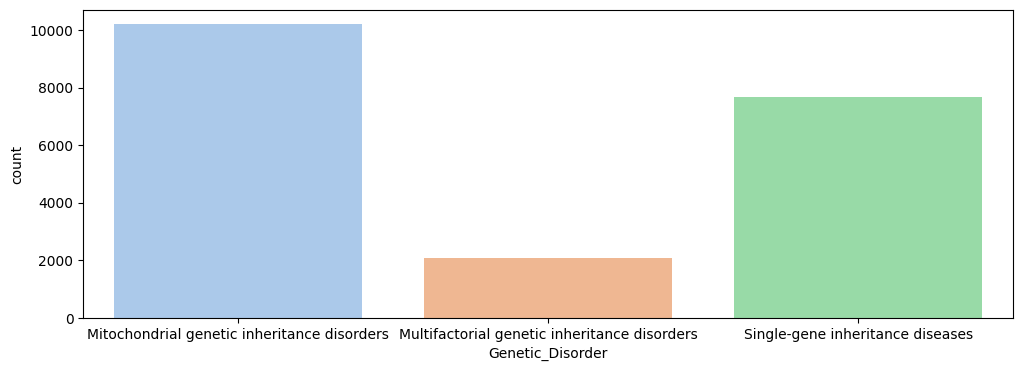

In [26]:

plt.figure(figsize=(12, 4))
sns.countplot(x = 'Genetic_Disorder', data = train_data,palette='pastel');

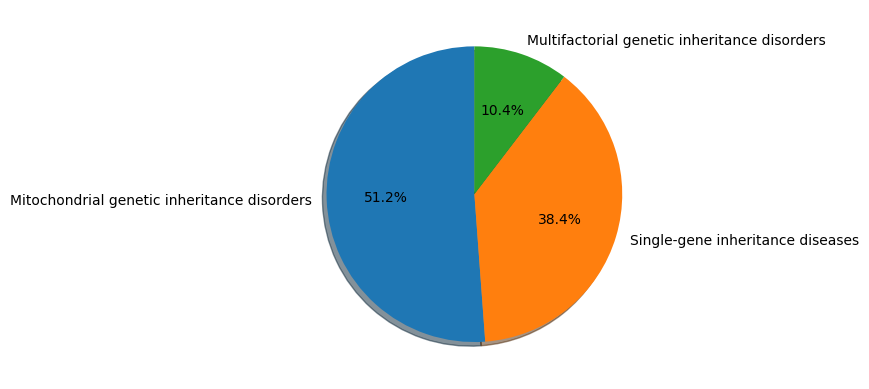

In [27]:
labels1 = 'Mitochondrial genetic inheritance disorders', 'Single-gene inheritance diseases', 'Multifactorial genetic inheritance disorders'
explode1 = (0, 0, 0)


plt.pie(train_data.Genetic_Disorder.value_counts(), explode=explode1, labels=labels1, autopct='%1.1f%%',
        shadow=True, startangle=90);

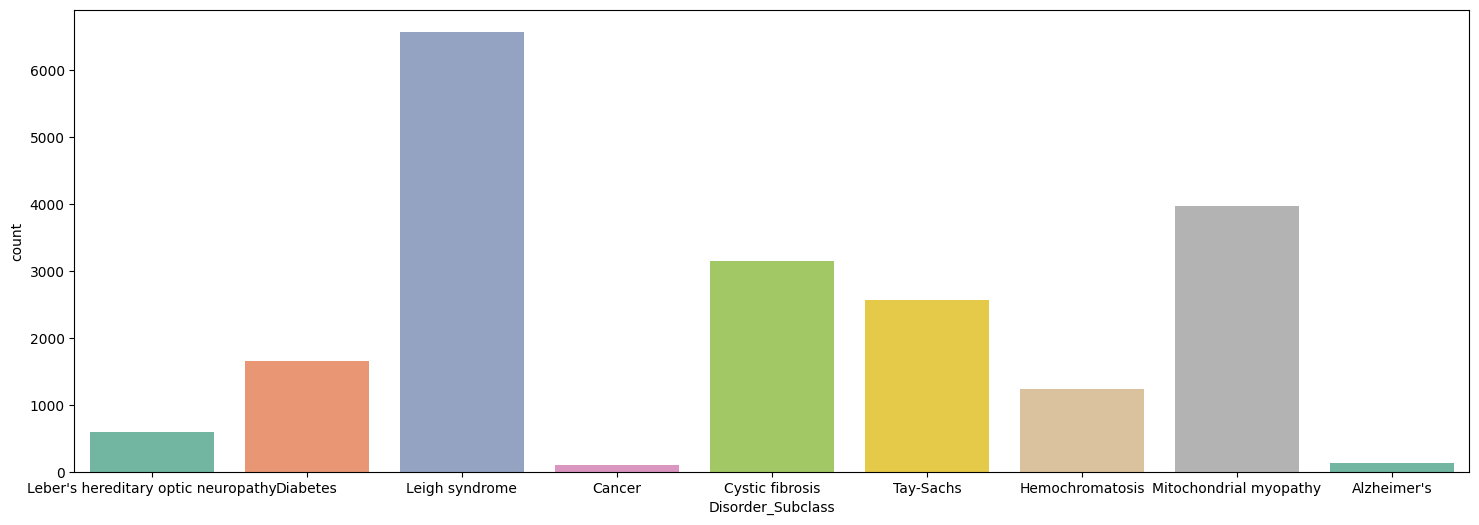

In [28]:
plt.figure(figsize=(18, 6))
sns.countplot(x = 'Disorder_Subclass', data = train_data, palette='Set2');

In [29]:
unique_subclasses = train_data.Disorder_Subclass.value_counts()
print(unique_subclasses)

Disorder_Subclass
Leigh syndrome                         6573
Mitochondrial myopathy                 3971
Cystic fibrosis                        3145
Tay-Sachs                              2556
Diabetes                               1653
Hemochromatosis                        1228
Leber's hereditary optic neuropathy     587
Alzheimer's                             133
Cancer                                   91
Name: count, dtype: int64


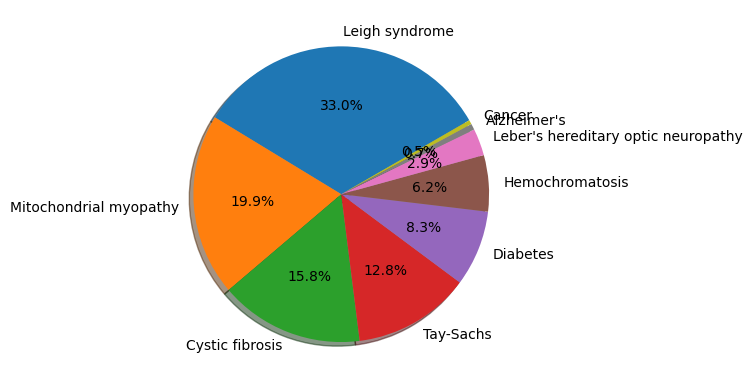

In [30]:

labels2 = ['Leigh syndrome', 'Mitochondrial myopathy', 'Cystic fibrosis', 'Tay-Sachs', 'Diabetes', 'Hemochromatosis',
"Leber's hereditary optic neuropathy", "Alzheimer's", 'Cancer']

explode2 = (0, 0, 0, 0, 0, 0, 0, 0,0)

plt.pie(train_data.Disorder_Subclass.value_counts(), explode=explode2, labels=labels2, autopct='%1.1f%%',
        shadow=True, startangle=30);

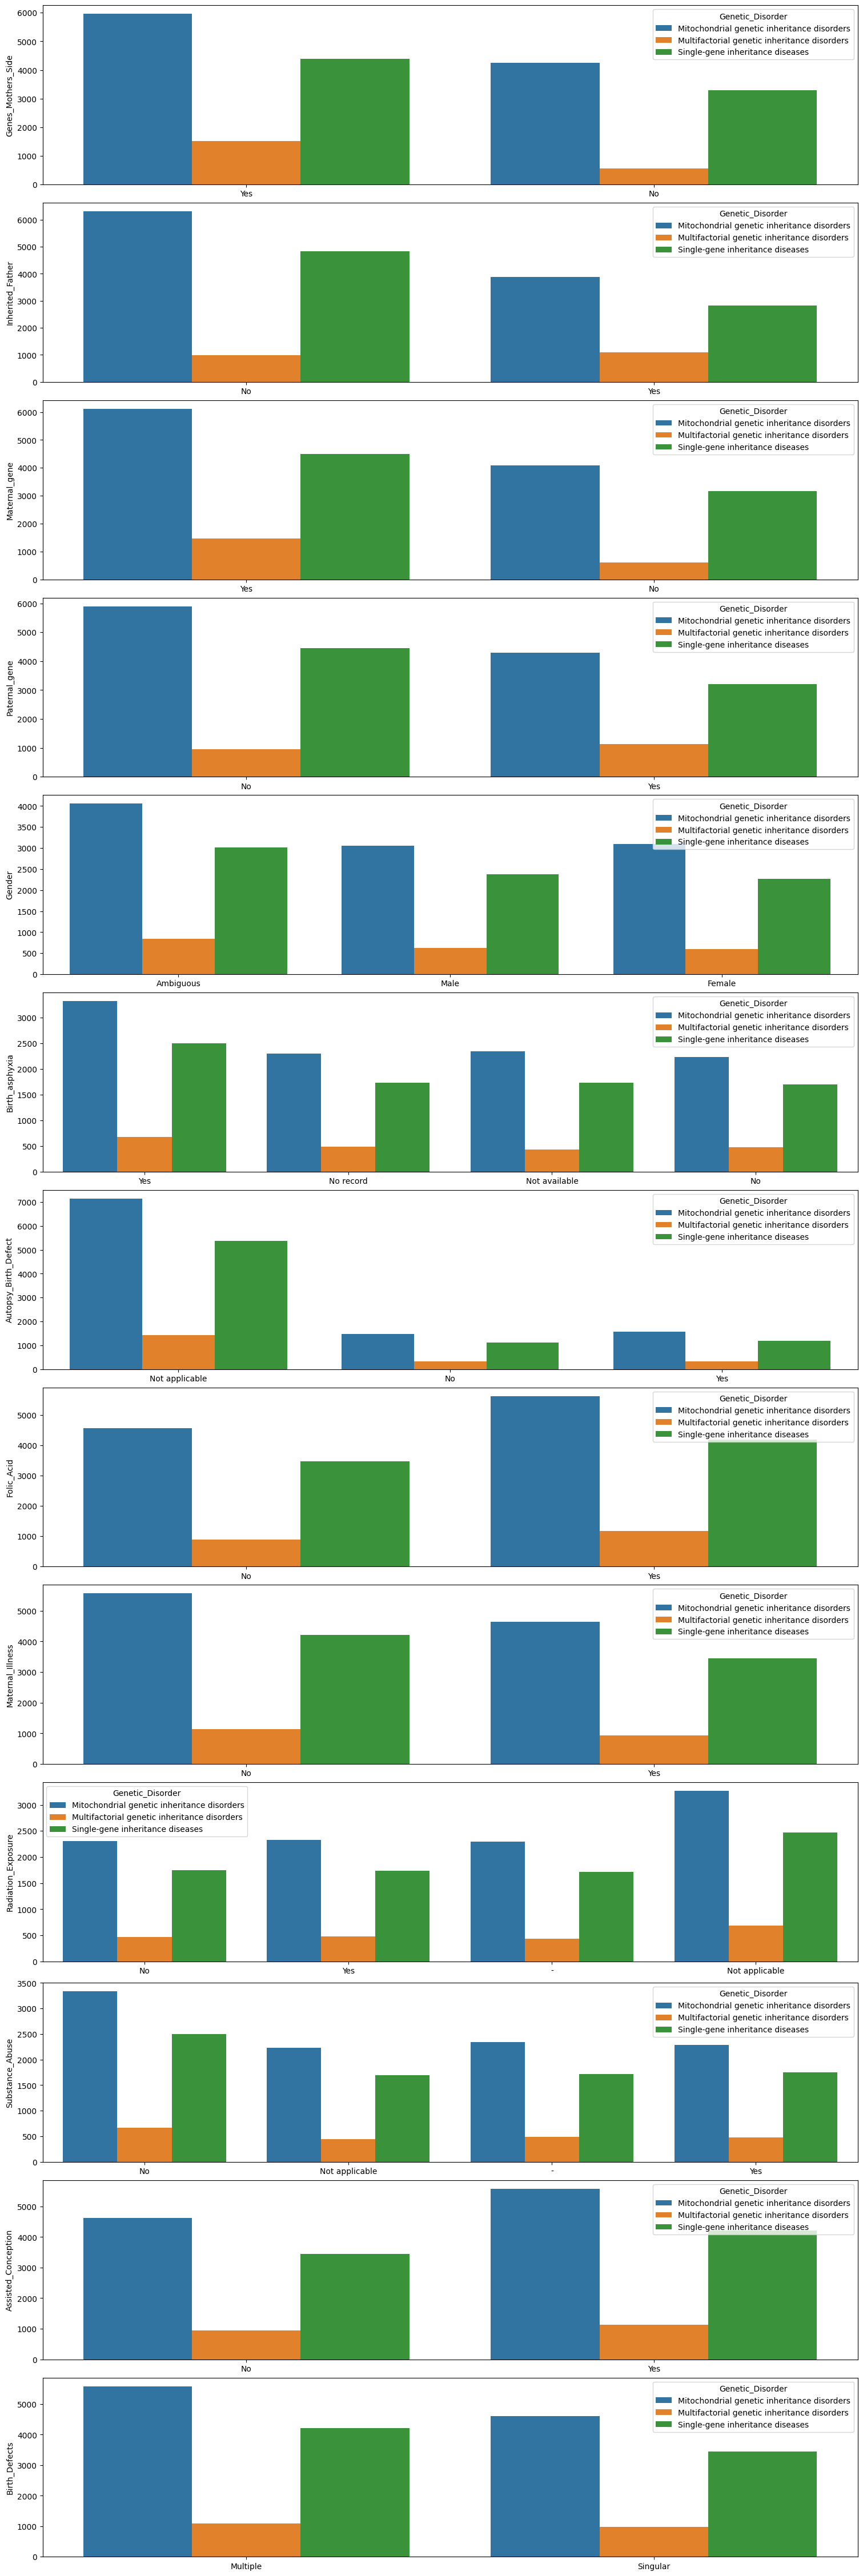

In [31]:
cols  = ['Genes_Mothers_Side', 'Inherited_Father', 'Maternal_gene', 'Paternal_gene', 
          'Gender', 'Birth_asphyxia', 'Autopsy_Birth_Defect', 
         'Folic_Acid',
        'Maternal_Illness',
         'Radiation_Exposure', 'Substance_Abuse', 'Assisted_Conception', 'Birth_Defects']


fig, ax = plt.subplots(len(cols),  figsize = (15, 45), constrained_layout = True)

for i, var in enumerate(cols): 
    sns.countplot(data = train_data, x = var, hue = 'Genetic_Disorder', ax = ax[i], linewidth = 1.5)
    ax[i].set_ylabel(var)
    ax[i].set_xlabel(None)

In [32]:
train_data

,Patient_Age,Genes_Mothers_Side,Inherited_Father,Maternal_gene,Paternal_gene,Blood_Cell_mcL,Mothers_age,Fathers_age,Status,Respiratory_Rate_breaths_min,...,Radiation_Exposure,Substance_Abuse,Assisted_Conception,History_Previous_Pregnancies,Previous_Abortion,Birth_Defects,White_Blood_Cell,Blood_test_result,Genetic_Disorder,Disorder_Subclass
0,2.0,Yes,No,Yes,No,4.760603,23.0,20.0,Alive,Normal (30-60),...,No,No,No,Yes,2.0,Multiple,9.857562,slightly abnormal,Mitochondrial genetic inheritance disorders,Leber's hereditary optic neuropathy
1,6.0,Yes,No,No,No,4.893297,41.0,22.0,Alive,Normal (30-60),...,Yes,No,Yes,Yes,4.0,Singular,7.472366,normal,Multifactorial genetic inheritance disorders,Diabetes
2,12.0,Yes,No,Yes,No,4.705280,21.0,20.0,Deceased,Tachypnea,...,-,Not applicable,Yes,Yes,1.0,Singular,7.919321,inconclusive,Mitochondrial genetic inheritance disorders,Leigh syndrome
3,11.0,Yes,No,Yes,Yes,4.720703,32.0,20.0,Alive,Tachypnea,...,-,Not applicable,Yes,No,4.0,Multiple,4.098210,slightly abnormal,Multifactorial genetic inheritance disorders,Cancer
4,14.0,Yes,No,Yes,No,5.103188,23.0,20.0,Deceased,Normal (30-60),...,No,No,Yes,No,0.0,Multiple,10.272230,normal,Single-gene inheritance diseases,Cystic fibrosis
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19932,9.0,No,Yes,Yes,Yes,5.012599,47.0,20.0,Deceased,Normal (30-60),...,No,Not applicable,Yes,Yes,2.0,Multiple,12.000000,slightly abnormal,Mitochondrial genetic inheritance disorders,Leigh syndrome
19933,4.0,Yes,Yes,Yes,No,5.258298,35.0,64.0,Deceased,Normal (30-60),...,Not applicable,No,Yes,No,3.0,Multiple,6.584811,inconclusive,Mitochondrial genetic inheritance disorders,Leigh syndrome
19934,8.0,No,Yes,No,Yes,4.974220,23.0,56.0,Alive,Normal (30-60),...,No,-,Yes,No,2.0,Multiple,7.041556,inconclusive,Multifactorial genetic inheritance disorders,Diabetes
19935,8.0,Yes,No,Yes,No,5.186470,35.0,51.0,Deceased,Tachypnea,...,Not applicable,No,No,No,2.0,Singular,7.715464,normal,Mitochondrial genetic inheritance disorders,Mitochondrial myopathy


Encoding

In [33]:
encode_train_data = train_data.copy()

In [34]:
# Columns to encode
columns_to_encode = [
    "Genes_Mothers_Side", "Inherited_Father", "Maternal_gene", "Paternal_gene", "Status",
    "Respiratory_Rate_breaths_min", "Heart_Rates_Min", "Parental_consent", "Follow_up",
    "Gender", "Birth_asphyxia", "Autopsy_Birth_Defect", "Folic_Acid", "Maternal_Illness",
    "Radiation_Exposure", "Substance_Abuse", "Assisted_Conception", 
    "History_Previous_Pregnancies", "Birth_Defects", "Blood_test_result", 
    "Genetic_Disorder", "Disorder_Subclass"
]

# Dictionary to store mappings for each column
encoding_mappings = {}

# Loop through each column and encode using pd.factorize()
for col in columns_to_encode:
    # Encode the column and get the unique values
    encode_train_data[col], unique_values = pd.factorize(encode_train_data[col])
    
    # Store the mapping of encoded values to original values
    encoding_mappings[col] = {index: value for index, value in enumerate(unique_values)}

# Print each column's encoding mappings one below the other
for col, mapping in encoding_mappings.items():
    print(f"Encoding mapping for '{col}':")
    for encoded_value, original_value in mapping.items():
        print(f"  {encoded_value}: {original_value}")
    print("\n")  # Blank line between columns for readability


Encoding mapping for 'Genes_Mothers_Side':
  0: Yes
  1: No


Encoding mapping for 'Inherited_Father':
  0: No
  1: Yes


Encoding mapping for 'Maternal_gene':
  0: Yes
  1: No


Encoding mapping for 'Paternal_gene':
  0: No
  1: Yes


Encoding mapping for 'Status':
  0: Alive
  1: Deceased


Encoding mapping for 'Respiratory_Rate_breaths_min':
  0: Normal (30-60)
  1: Tachypnea


Encoding mapping for 'Heart_Rates_Min':
  0: Normal
  1: Tachycardia


Encoding mapping for 'Parental_consent':
  0: Yes


Encoding mapping for 'Follow_up':
  0: High
  1: Low


Encoding mapping for 'Gender':
  0: Ambiguous
  1: Male
  2: Female


Encoding mapping for 'Birth_asphyxia':
  0: Yes
  1: No record
  2: Not available
  3: No


Encoding mapping for 'Autopsy_Birth_Defect':
  0: Not applicable
  1: No
  2: Yes


Encoding mapping for 'Folic_Acid':
  0: No
  1: Yes


Encoding mapping for 'Maternal_Illness':
  0: No
  1: Yes


Encoding mapping for 'Radiation_Exposure':
  0: No
  1: Yes
  2: -
  3: Not ap

In [35]:
encode_train_data

,Patient_Age,Genes_Mothers_Side,Inherited_Father,Maternal_gene,Paternal_gene,Blood_Cell_mcL,Mothers_age,Fathers_age,Status,Respiratory_Rate_breaths_min,...,Radiation_Exposure,Substance_Abuse,Assisted_Conception,History_Previous_Pregnancies,Previous_Abortion,Birth_Defects,White_Blood_Cell,Blood_test_result,Genetic_Disorder,Disorder_Subclass
0,2.0,0,0,0,0,4.760603,23.0,20.0,0,0,...,0,0,0,0,2.0,0,9.857562,0,0,0
1,6.0,0,0,1,0,4.893297,41.0,22.0,0,0,...,1,0,1,0,4.0,1,7.472366,1,1,1
2,12.0,0,0,0,0,4.705280,21.0,20.0,1,1,...,2,1,1,0,1.0,1,7.919321,2,0,2
3,11.0,0,0,0,1,4.720703,32.0,20.0,0,1,...,2,1,1,1,4.0,0,4.098210,0,1,3
4,14.0,0,0,0,0,5.103188,23.0,20.0,1,0,...,0,0,1,1,0.0,0,10.272230,1,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19932,9.0,1,1,0,1,5.012599,47.0,20.0,1,0,...,0,1,1,0,2.0,0,12.000000,0,0,2
19933,4.0,0,1,0,0,5.258298,35.0,64.0,1,0,...,3,0,1,1,3.0,0,6.584811,2,0,2
19934,8.0,1,1,1,1,4.974220,23.0,56.0,0,0,...,0,2,1,1,2.0,0,7.041556,2,1,1
19935,8.0,0,0,0,0,5.186470,35.0,51.0,1,1,...,3,0,0,1,2.0,1,7.715464,1,0,7


Unique values in 'Genetic_Disorder': [0 1 2]


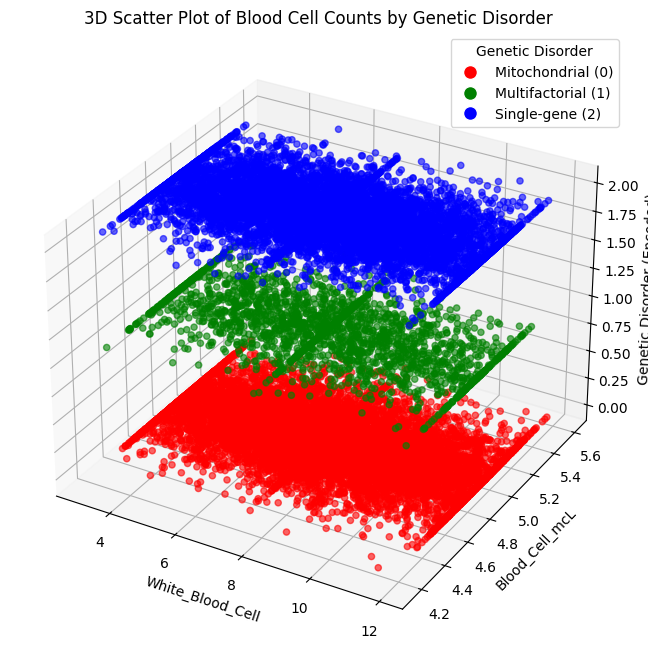

In [37]:
# Check unique values in the 'Genetic_Disorder' column
print("Unique values in 'Genetic_Disorder':", encode_train_data['Genetic_Disorder'].unique())


# Create a figure and a 3D subplot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Define colors for different Genetic_Disorder categories
colors = {0: 'r', 1: 'g', 2: 'b'}

# Create the 3D scatter plot
ax.scatter(
    encode_train_data['White_Blood_Cell'],
    encode_train_data['Blood_Cell_mcL'],
    encode_train_data['Genetic_Disorder'],
    c=encode_train_data['Genetic_Disorder'].map(colors),
    alpha=0.6
)

# Setting labels and title
ax.set_xlabel('White_Blood_Cell')
ax.set_ylabel('Blood_Cell_mcL')
ax.set_zlabel('Genetic Disorder (Encoded)')
ax.set_title('3D Scatter Plot of Blood Cell Counts by Genetic Disorder')

# Create a legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) 
           for color in colors.values()]
labels = ['Mitochondrial (0)', 'Multifactorial (1)', 'Single-gene (2)']
ax.legend(handles, labels, title='Genetic Disorder')

# Show the plot
plt.show()


In [41]:
#encode_train_data = encode_train_data.astype("float32")

In [38]:
encode_train_data

,Patient_Age,Genes_Mothers_Side,Inherited_Father,Maternal_gene,Paternal_gene,Blood_Cell_mcL,Mothers_age,Fathers_age,Status,Respiratory_Rate_breaths_min,...,Radiation_Exposure,Substance_Abuse,Assisted_Conception,History_Previous_Pregnancies,Previous_Abortion,Birth_Defects,White_Blood_Cell,Blood_test_result,Genetic_Disorder,Disorder_Subclass
0,2.0,0,0,0,0,4.760603,23.0,20.0,0,0,...,0,0,0,0,2.0,0,9.857562,0,0,0
1,6.0,0,0,1,0,4.893297,41.0,22.0,0,0,...,1,0,1,0,4.0,1,7.472366,1,1,1
2,12.0,0,0,0,0,4.705280,21.0,20.0,1,1,...,2,1,1,0,1.0,1,7.919321,2,0,2
3,11.0,0,0,0,1,4.720703,32.0,20.0,0,1,...,2,1,1,1,4.0,0,4.098210,0,1,3
4,14.0,0,0,0,0,5.103188,23.0,20.0,1,0,...,0,0,1,1,0.0,0,10.272230,1,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19932,9.0,1,1,0,1,5.012599,47.0,20.0,1,0,...,0,1,1,0,2.0,0,12.000000,0,0,2
19933,4.0,0,1,0,0,5.258298,35.0,64.0,1,0,...,3,0,1,1,3.0,0,6.584811,2,0,2
19934,8.0,1,1,1,1,4.974220,23.0,56.0,0,0,...,0,2,1,1,2.0,0,7.041556,2,1,1
19935,8.0,0,0,0,0,5.186470,35.0,51.0,1,1,...,3,0,0,1,2.0,1,7.715464,1,0,7


In [39]:
print("INFO:\n")
encode_train_data.info()

INFO:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19937 entries, 0 to 19936
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Patient_Age                   19937 non-null  float64
 1   Genes_Mothers_Side            19937 non-null  int64  
 2   Inherited_Father              19937 non-null  int64  
 3   Maternal_gene                 19937 non-null  int64  
 4   Paternal_gene                 19937 non-null  int64  
 5   Blood_Cell_mcL                19937 non-null  float64
 6   Mothers_age                   19937 non-null  float64
 7   Fathers_age                   19937 non-null  float64
 8   Status                        19937 non-null  int64  
 9   Respiratory_Rate_breaths_min  19937 non-null  int64  
 10  Heart_Rates_Min               19937 non-null  int64  
 11  Parental_consent              19937 non-null  int64  
 12  Follow_up                     19937 non-null  int64  

In [77]:
# Assuming 'Genetic Disorder' is the target column with the specified classes
X = encode_train_data.drop(['Genetic_Disorder'], axis=1)  # Drop the target column from features
y = encode_train_data['Genetic_Disorder']  # Set target variable

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE for multiclass targets
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Display the class distribution after applying SMOTE
print("Class distribution before SMOTE:\n", y_train.value_counts())
print("Class distribution after SMOTE:\n", y_train_res.value_counts())


Class distribution before SMOTE:
 Genetic_Disorder
0    8154
2    6133
1    1662
Name: count, dtype: int64
Class distribution after SMOTE:
 Genetic_Disorder
0    8154
2    8154
1    8154
Name: count, dtype: int64


In [78]:
y_train_res

0        0
1        0
2        2
3        2
4        1
        ..
24457    2
24458    2
24459    2
24460    2
24461    2
Name: Genetic_Disorder, Length: 24462, dtype: int64

 0: Mitochondrial genetic inheritance disorders
  1: Multifactorial genetic inheritance disorders
  2: Single-gene inheritance diseases

In [79]:

# Convert the SMOTE-resampled target data back into a DataFrame for plotting
y_train_res_df = pd.DataFrame(y_train_res, columns=['Genetic_Disorder'])

In [80]:
# Define a mapping dictionary
disorder_mapping = {
    0: 'Mitochondrial genetic inheritance disorders',
    1: 'Multifactorial genetic inheritance disorders',
    2: 'Single-gene inheritance diseases'
}

# Map the numeric values to disorder names
y_train_res_df['Genetic_Disorder'] = y_train_res_df['Genetic_Disorder'].replace(disorder_mapping)


In [81]:
y_train_res_df

,Genetic_Disorder
0,Mitochondrial genetic inheritance disorders
1,Mitochondrial genetic inheritance disorders
2,Single-gene inheritance diseases
3,Single-gene inheritance diseases
4,Multifactorial genetic inheritance disorders
...,...
24457,Single-gene inheritance diseases
24458,Single-gene inheritance diseases
24459,Single-gene inheritance diseases
24460,Single-gene inheritance diseases


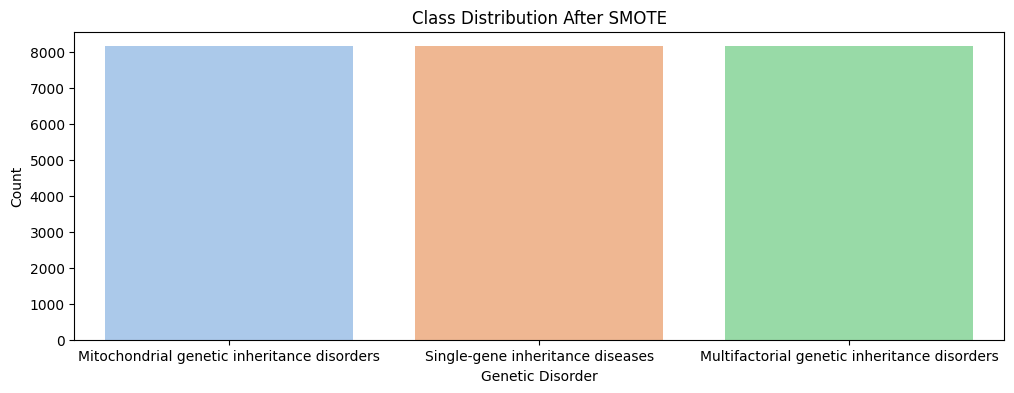

In [82]:
# Plot the balanced class distribution
plt.figure(figsize=(12, 4))
sns.countplot(x='Genetic_Disorder', data=y_train_res_df, palette='pastel')
plt.title('Class Distribution After SMOTE')
plt.xlabel('Genetic Disorder')
plt.ylabel('Count')
plt.show()


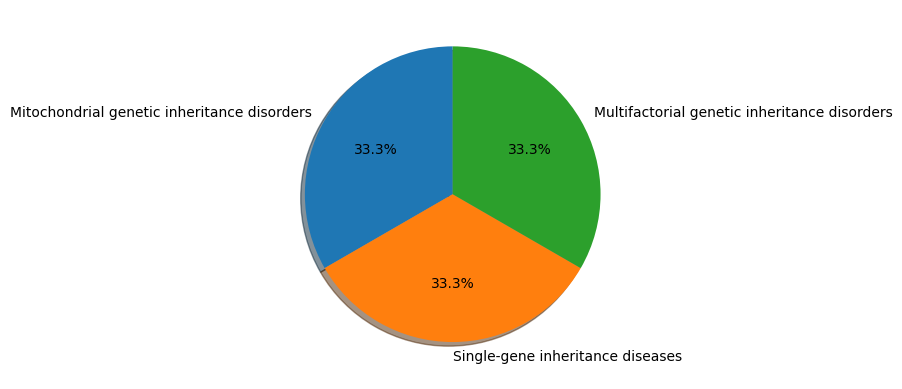

In [98]:
labels_disorder = 'Mitochondrial genetic inheritance disorders', 'Single-gene inheritance diseases', 'Multifactorial genetic inheritance disorders'
explode_disorder = (0, 0, 0)


plt.pie(y_train_res_df.Genetic_Disorder.value_counts(), explode=explode_disorder, labels=labels_disorder, autopct='%1.1f%%',
        shadow=True, startangle=90);

In [85]:
X_train_res.columns

Index(['Patient_Age', 'Genes_Mothers_Side', 'Inherited_Father',
       'Maternal_gene', 'Paternal_gene', 'Blood_Cell_mcL', 'Mothers_age',
       'Fathers_age', 'Status', 'Respiratory_Rate_breaths_min',
       'Heart_Rates_Min', 'Parental_consent', 'Follow_up', 'Gender',
       'Birth_asphyxia', 'Autopsy_Birth_Defect', 'Folic_Acid',
       'Maternal_Illness', 'Radiation_Exposure', 'Substance_Abuse',
       'Assisted_Conception', 'History_Previous_Pregnancies',
       'Previous_Abortion', 'Birth_Defects', 'White_Blood_Cell',
       'Blood_test_result', 'Disorder_Subclass', 'Genetic_Disorder'],
      dtype='object')

In [94]:
# Assuming y_train_res is the resampled target variable from SMOTE
X_train_res['Genetic_Disorder'] = y_train_res.values

In [95]:
X_train_res_df = pd.DataFrame(X_train_res, columns=['Patient_Age', 'Genes_Mothers_Side', 'Inherited_Father',
       'Maternal_gene', 'Paternal_gene', 'Blood_Cell_mcL', 'Mothers_age',
       'Fathers_age', 'Status', 'Respiratory_Rate_breaths_min',
       'Heart_Rates_Min', 'Parental_consent', 'Follow_up', 'Gender',
       'Birth_asphyxia', 'Autopsy_Birth_Defect', 'Folic_Acid',
       'Maternal_Illness', 'Radiation_Exposure', 'Substance_Abuse',
       'Assisted_Conception', 'History_Previous_Pregnancies',
       'Previous_Abortion', 'Birth_Defects', 'White_Blood_Cell',
       'Blood_test_result', 'Disorder_Subclass', 'Genetic_Disorder'])

In [96]:
# Define a mapping dictionary
disorder_mapping = {
    0: 'Mitochondrial genetic inheritance disorders',
    1: 'Multifactorial genetic inheritance disorders',
    2: 'Single-gene inheritance diseases'
}

# Map the numeric values to disorder names
X_train_res_df['Genetic_Disorder'] = X_train_res_df['Genetic_Disorder'].replace(disorder_mapping)

Encoding mapping for 'Genes_Mothers_Side':
  0: Yes
  1: No


Encoding mapping for 'Inherited_Father':
  0: No
  1: Yes


Encoding mapping for 'Maternal_gene':
  0: Yes
  1: No


Encoding mapping for 'Paternal_gene':
  0: No
  1: Yes


Encoding mapping for 'Gender':
  0: Ambiguous
  1: Male
  2: Female


Encoding mapping for 'Birth_asphyxia':
  0: Yes
  1: No record
  2: Not available
  3: No


Encoding mapping for 'Autopsy_Birth_Defect':
  0: Not applicable
  1: No
  2: Yes


Encoding mapping for 'Folic_Acid':
  0: No
  1: Yes


Encoding mapping for 'Maternal_Illness':
  0: No
  1: Yes


Encoding mapping for 'Radiation_Exposure':
  0: No
  1: Yes
  2: -
  3: Not applicable


Encoding mapping for 'Substance_Abuse':
  0: No
  1: Not applicable
  2: -
  3: Yes


Encoding mapping for 'Assisted_Conception':
  0: No
  1: Yes


Encoding mapping for 'Birth_Defects':
  0: Multiple
  1: Singular


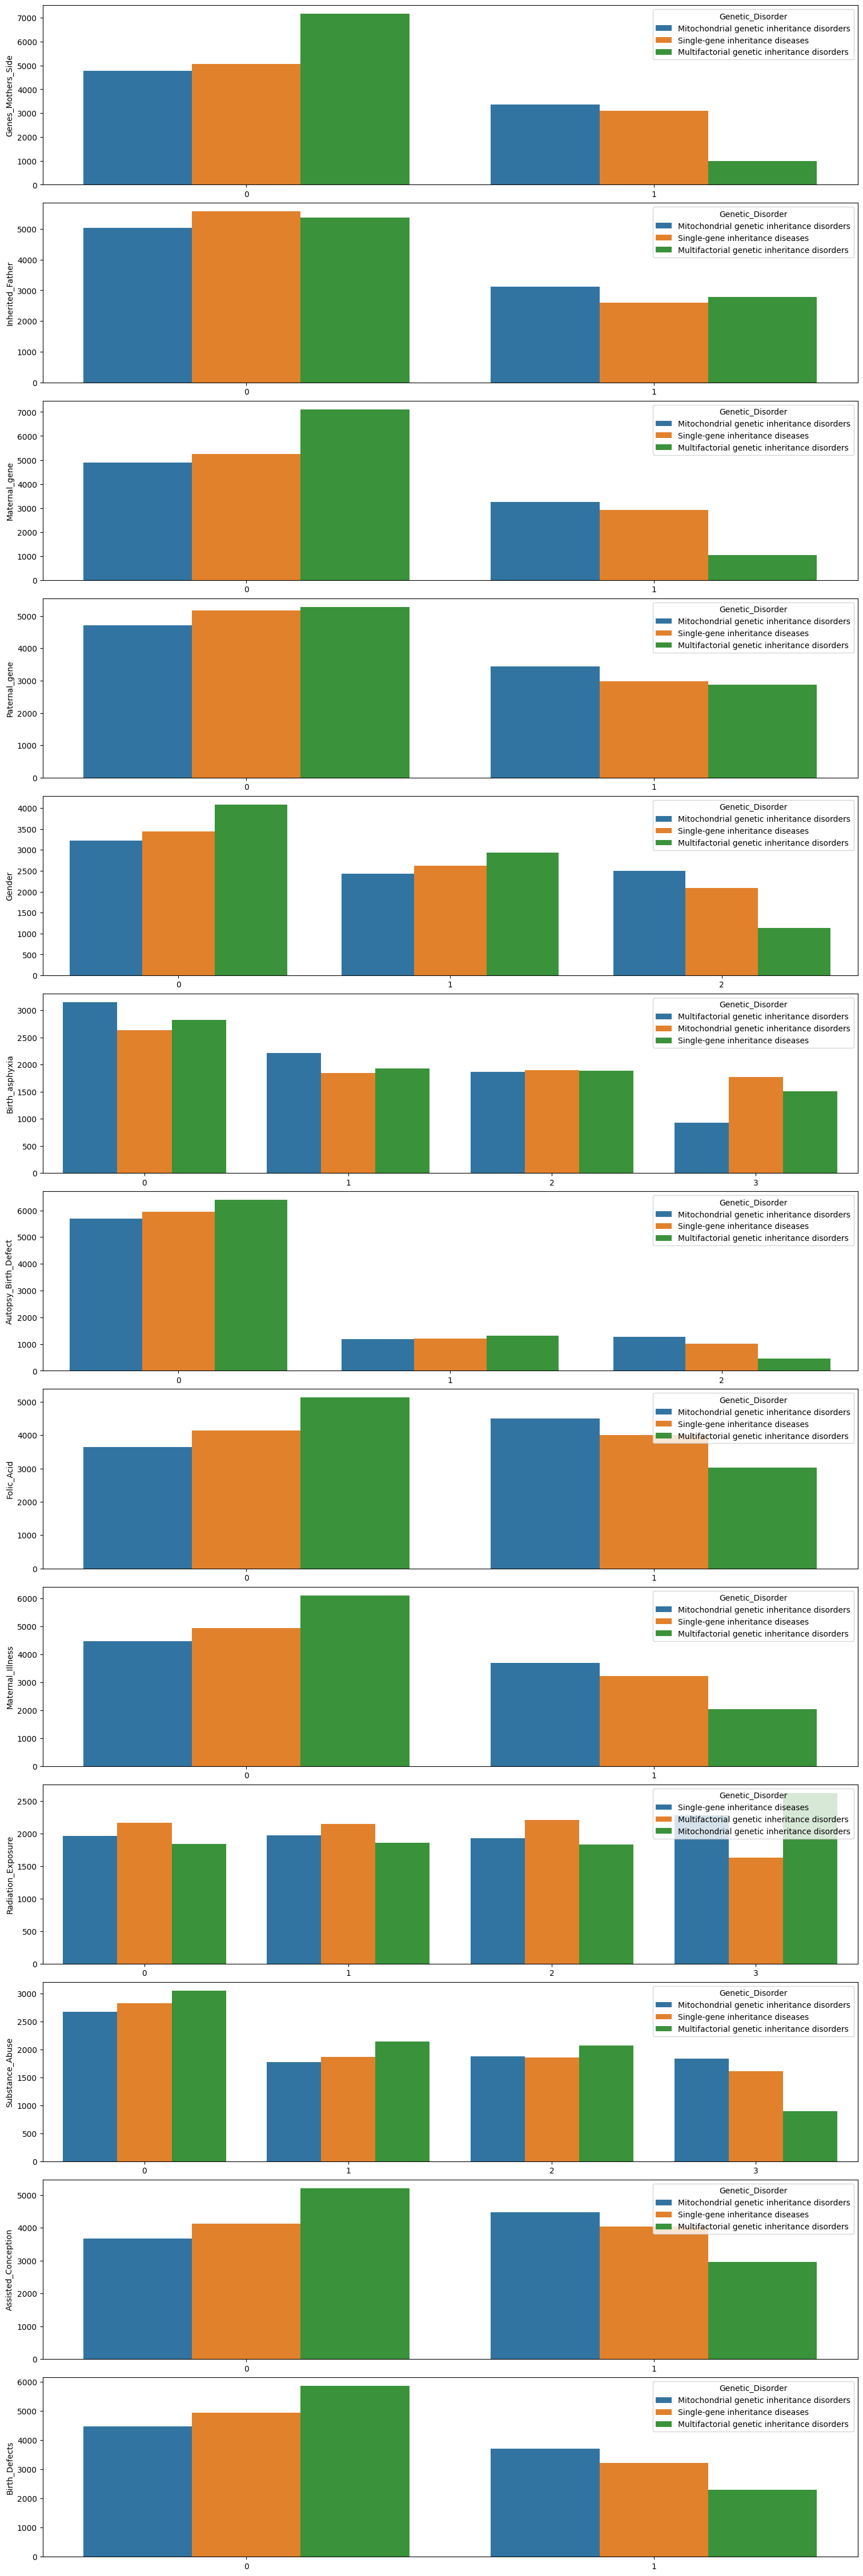

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the columns for plotting
cols = [
    'Genes_Mothers_Side', 'Inherited_Father', 'Maternal_gene', 'Paternal_gene', 
    'Gender', 'Birth_asphyxia', 'Autopsy_Birth_Defect', 
    'Folic_Acid', 'Maternal_Illness',
    'Radiation_Exposure', 'Substance_Abuse', 
    'Assisted_Conception', 'Birth_Defects'
]

# Create subplots
fig, ax = plt.subplots(len(cols), figsize=(15, 45), constrained_layout=True)

# Plot each categorical column with hue as 'Genetic_Disorder'
for i, var in enumerate(cols): 
    sns.countplot(data=X_train_res_df, x=var, hue='Genetic_Disorder', ax=ax[i], linewidth=1.5)
    ax[i].set_ylabel(var)
    ax[i].set_xlabel(None)

# Show the plots
plt.show()
